# MATH pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results`, then plot how RL fine-tuning moves performance from its starting checkpoint.



In [1]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Root locations for evaluation outputs and the metric key to read
BASE_DIRS = [
    Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results"),
    Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny"),
]
DATASET_KEY = "test_score/DigitalLearningGmbH/MATH-lighteval"
DATASET_NAME = "MATH"

print(f"Base directories: {BASE_DIRS}")

Base directories: [PosixPath('/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results'), PosixPath('/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny')]


In [2]:
def read_score(result_path: Path, samples: int, dataset_key: str = DATASET_KEY):
    """Read score from either dict-style logs or majority-vote text.

    Returns:
        dict[int, float]: Dictionary mapping k values to scores.
                         For majority files, returns all Pass@k values found.
                         For dict-style files, returns {samples: score}.
                         Returns {} if no scores found.
    """
    if not result_path.exists():
        return {}

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        scores = {}
        for line in text:
            if "Pass@" in line and ":" in line:
                # Expect formats like: "  Pass@1 : 0.0403 (4.03%)" or "Pass@32 (Any Correct):  0.6884 (68.84%)"
                # Extract k value and score
                import re as _re
                # Match "Pass@<k>" pattern
                k_match = _re.search(r"Pass@(\d+)", line)
                if k_match:
                    k = int(k_match.group(1))
                    # Extract score after the colon
                    parts = line.split(":")
                    if len(parts) > 1:
                        try:
                            score = float(parts[1].split()[0])
                            scores[k] = score
                        except Exception:
                            pass
        if scores:
            return scores
        # If we didn't find Pass@, fall back to the dict parsing below

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return {samples: payload[dataset_key]}
    return {}

# Patterns for matching directory names
# Pre-train pattern
pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")

# RL patterns
rl_patterns = [
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omi_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
]

# SFT patterns
sft_patterns = [
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-(?P<sft_dataset>openmath(?:gsm8k)?)-(?:\d+epoch-)?step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
]

# Collect runs from all directories
pretrain_rows = []
rl_rows = []
sft_rows = []

for BASE_DIR in BASE_DIRS:
    if not BASE_DIR.exists():
        print(f"Warning: {BASE_DIR} does not exist, skipping...")
        continue
    
    print(f"Collecting from {BASE_DIR}...")
    
    for path in BASE_DIR.iterdir():
        if not path.is_dir():
            continue
        name = path.name

        # Pre-train collection
        pre_match = pre_pattern.match(name)
        if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
            samples = int(pre_match.group("samples"))
            result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
            scores_dict = read_score(path / result_file, samples=samples)
            
            # Create a row for each k value found
            for k, score in scores_dict.items():
                pretrain_rows.append(
                    {
                        "step": int(pre_match.group("step")),
                        "shot": int(pre_match.group("shot")),
                        "samples": k,  # Use the actual k value extracted from read_score
                        "temp": float(pre_match.group("temp")),
                        "score": score,
                        "path": str(path),
                    }
                )
            continue

        # RL collection (first pattern that matches wins)
        matched = False
        for pat in rl_patterns:
            rl_match = pat.match(name)
            if rl_match:
                samples = int(rl_match.group("samples"))
                result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
                scores_dict = read_score(path / result_file, samples=samples)
                pt_step = int(rl_match.group("pt_step"))
                rl_step = int(rl_match.group("rl_step"))
                num_rollouts = int(rl_match.group("num_rollouts")) if "num_rollouts" in rl_match.groupdict() and rl_match.group("num_rollouts") else 5
                
                # Create a row for each k value found
                for k, score in scores_dict.items():
                    rl_rows.append(
                        {
                            "pt_step": pt_step,
                            "rl_step": rl_step,
                            "total_step": pt_step + rl_step,
                            "samples": k,  # Use the actual k value extracted from read_score
                            "temp": float(rl_match.group("temp")),
                            "num_rollouts": num_rollouts,
                            "score": score,
                            "path": str(path),
                            "label": name,
                        }
                    )
                matched = True
                break
        if matched:
            continue

        # SFT collection (first pattern that matches wins)
        for pat in sft_patterns:
            sft_match = pat.match(name)
            if sft_match:
                samples = int(sft_match.group("samples"))
                shot = int(sft_match.group("shot")) if "shot" in sft_match.groupdict() else None
                result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
                scores_dict = read_score(path / result_file, samples=samples)
                pt_step = int(sft_match.group("pt_step"))
                sft_step = int(sft_match.group("sft_step"))
                # Detect epoch count from directory name
                if "10epoch" in name:
                    epochs = 10
                elif "5epoch" in name:
                    epochs = 5
                else:
                    epochs = 1
                
                # Create a row for each k value found
                for k, score in scores_dict.items():
                    sft_rows.append(
                        {
                            "pt_step": pt_step,
                            "sft_step": sft_step,
                            "total_step": pt_step + sft_step,
                            "shot": shot,
                            "samples": k,  # Use the actual k value extracted from read_score
                            "temp": float(sft_match.group("temp")),
                            "score": score,
                            "path": str(path),
                            "label": name,
                            "sft_epochs": epochs,
                            "sft_dataset": sft_match.group("sft_dataset").lower(),
                        }
                    )
                break

# Create dataframes
pre_df = pd.DataFrame(pretrain_rows)
rl_df = pd.DataFrame(rl_rows)
sft_df = pd.DataFrame(sft_rows)

print(f"Loaded {len(pre_df)} pre-train runs, {len(rl_df)} RL runs, {len(sft_df)} SFT runs.")

# Remove duplicates - keep first occurrence
print(f"Removing duplicates...")
pre_df_before = len(pre_df)
rl_df_before = len(rl_df)
sft_df_before = len(sft_df)

# Only drop duplicates if dataframe is not empty
if not pre_df.empty:
    pre_df = pre_df.drop_duplicates(subset=['step', 'shot', 'samples', 'temp'], keep='first')
if not rl_df.empty:
    rl_df = rl_df.drop_duplicates(subset=['pt_step', 'rl_step', 'samples', 'temp', 'num_rollouts'], keep='first')
if not sft_df.empty:
    sft_df = sft_df.drop_duplicates(subset=['pt_step', 'sft_step', 'samples', 'temp', 'shot', 'sft_epochs', 'sft_dataset'], keep='first')

print(f"Pre-train: {pre_df_before} → {len(pre_df)} ({pre_df_before - len(pre_df)} duplicates removed)")
print(f"RL: {rl_df_before} → {len(rl_df)} ({rl_df_before - len(rl_df)} duplicates removed)")
print(f"SFT: {sft_df_before} → {len(sft_df)} ({sft_df_before - len(sft_df)} duplicates removed)")

# Show breakdown by samples
if not rl_df.empty:
    print("\nRL runs by samples:")
    print(rl_df.groupby('samples').size())

Loaded 108 pre-train runs, 559 RL runs, 90 SFT runs.
Removing duplicates...
Pre-train: 108 → 90 (18 duplicates removed)
RL: 559 → 478 (81 duplicates removed)
SFT: 90 → 90 (0 duplicates removed)

RL runs by samples:
samples
1      97
2      61
4      61
5      54
8      72
16     61
32     71
128     1
dtype: int64


In [3]:
if not pre_df.empty:
    display(pre_df.sort_values(["step", "shot", "samples", "temp"]))
else:
    print("Pre-train dataframe is empty")
print()

if not rl_df.empty:
    display(rl_df.sort_values(["pt_step", "rl_step", "samples", "temp"]))
else:
    print("RL dataframe is empty")
print()

if not sft_df.empty:
    display(sft_df.sort_values(["pt_step", "sft_step", "samples", "temp"]))
else:
    print("SFT dataframe is empty")


,step,shot,samples,temp,score,path
0,1000,1,1,0.6,0.0076,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,1,8,0.6,0.0230,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
1,1000,1,32,0.6,0.0300,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
3,1000,8,1,0.6,0.0050,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
5,1000,8,2,0.6,0.0066,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
54,22000,8,2,0.6,0.0176,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
55,22000,8,4,0.6,0.0332,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
56,22000,8,8,0.6,0.0601,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
57,22000,8,16,0.6,0.1029,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


,pt_step,rl_step,total_step,samples,temp,num_rollouts,score,path,label
63,1000,100,1100,1,0.6,64,0.0328,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...
302,1000,100,1100,2,0.6,64,0.0432,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...
303,1000,100,1100,4,0.6,64,0.0536,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...
65,1000,100,1100,8,0.6,64,0.0664,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...
305,1000,100,1100,16,0.6,64,0.0763,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...
...,...,...,...,...,...,...,...,...,...
133,22000,2200,24200,8,0.6,5,0.1012,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2200-rl-0shot-bo...
132,22000,2200,24200,32,0.6,5,0.1174,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2200-rl-0shot-bo...
134,22000,2700,24700,1,0.6,5,0.0796,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2700-rl-0shot-bo...
136,22000,2700,24700,8,0.6,5,0.1044,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2700-rl-0shot-bo...


,pt_step,sft_step,total_step,shot,samples,temp,score,path,label,sft_epochs,sft_dataset
0,1000,12732,13732,0,1,0.6,0.1146,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step1000-stage2-openmath-5epoch-step1...,5,openmath
1,1000,12732,13732,0,2,0.6,0.1802,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step1000-stage2-openmath-5epoch-step1...,5,openmath
2,1000,12732,13732,0,4,0.6,0.2596,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step1000-stage2-openmath-5epoch-step1...,5,openmath
3,1000,12732,13732,0,8,0.6,0.3469,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step1000-stage2-openmath-5epoch-step1...,5,openmath
4,1000,12732,13732,0,16,0.6,0.4374,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step1000-stage2-openmath-5epoch-step1...,5,openmath
...,...,...,...,...,...,...,...,...,...,...,...
37,22000,8000,30000,0,2,0.6,0.3118,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmath-5epoch-step...,5,openmath
38,22000,8000,30000,0,4,0.6,0.4117,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmath-5epoch-step...,5,openmath
39,22000,8000,30000,0,8,0.6,0.5043,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmath-5epoch-step...,5,openmath
40,22000,8000,30000,0,16,0.6,0.5871,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmath-5epoch-step...,5,openmath


In [4]:
# Drop NA rows from RL dataframe
rl_df = rl_df.dropna()

print(f"After dropping NA: {len(rl_df)} RL runs")

After dropping NA: 478 RL runs


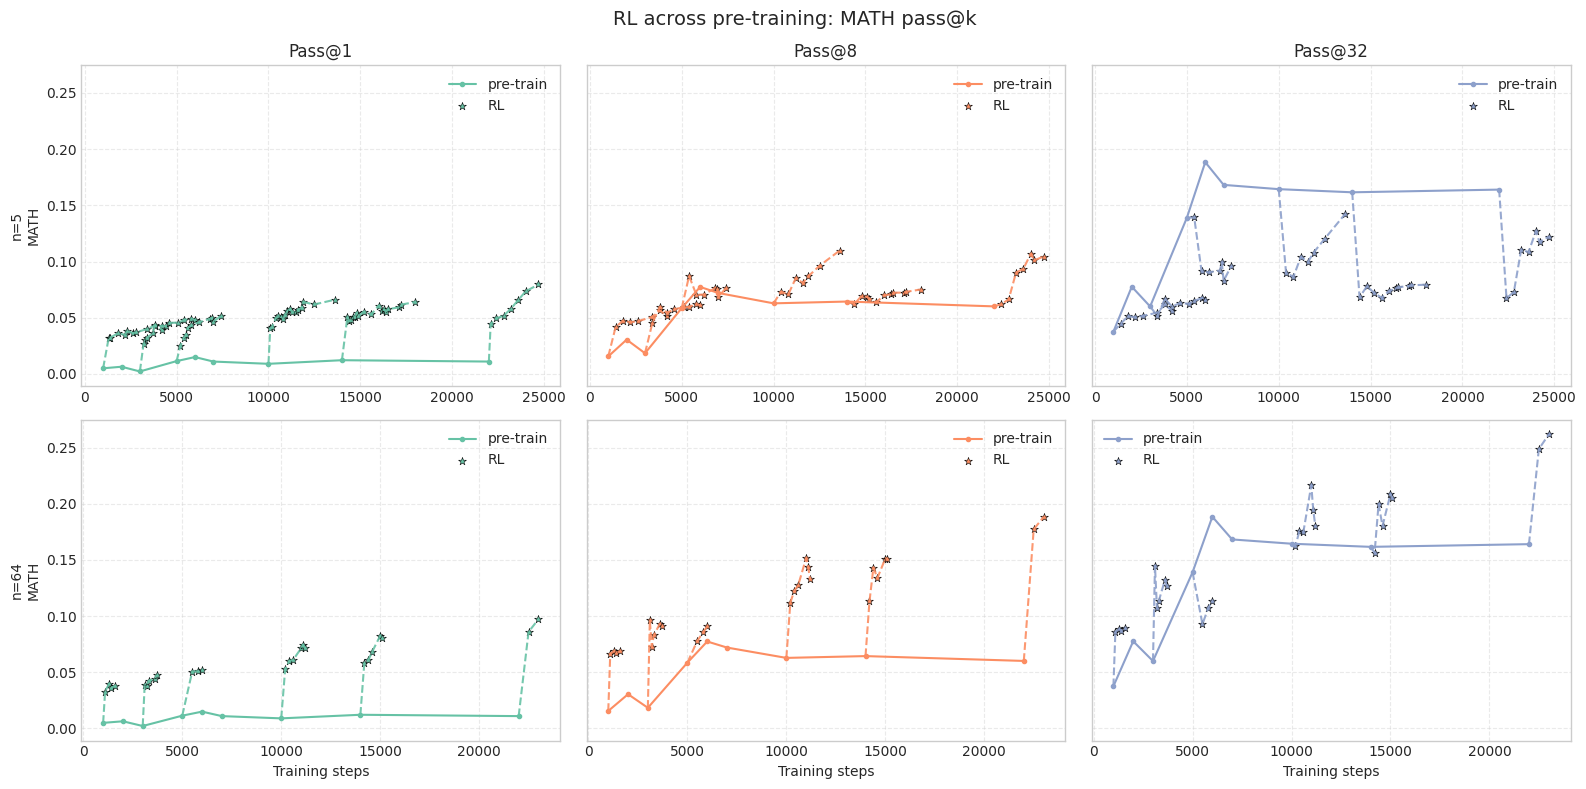

In [5]:
# Refined plotting: per-k subplots, cleaner legend markers, no RL/SFT marker at start
PLOT_SAMPLES = [1, 8, 32]
BASE_PRETRAIN_SHOT = 8
SHOT_BY_SAMPLES = lambda s: BASE_PRETRAIN_SHOT
TEMP_BY_SAMPLES = lambda s: 0.6
FILTER_NUM_ROLLOUTS_LIST = [5, 64]  # Plot both n=5 and n=64

# Get available samples from non-empty dataframes
available_samples_sets = []
if not pre_df.empty:
    available_samples_sets.append(set(pre_df["samples"]))
if not rl_df.empty:
    available_samples_sets.append(set(rl_df["samples"]))
if not sft_df.empty:
    available_samples_sets.append(set(sft_df["samples"]))

available_samples = sorted(set().union(*available_samples_sets)) if available_samples_sets else []
plot_samples = [s for s in PLOT_SAMPLES if s in available_samples]

plt.style.use("seaborn-v0_8-whitegrid")

if not plot_samples:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.text(0.5, 0.5, "No runs for the selected samples/temp", transform=ax.transAxes, ha="center")
    plt.show()
else:
    n_samples = len(plot_samples)
    n_rollouts = len(FILTER_NUM_ROLLOUTS_LIST)
    
    # Create 2 rows (one for each rollout config) x 3 columns (one for each pass@k)
    fig, axes = plt.subplots(n_rollouts, n_samples, figsize=(16, 4 * n_rollouts), sharey=True)
    if n_rollouts == 1:
        axes = axes.reshape(1, -1)
    if n_samples == 1:
        axes = axes.reshape(-1, 1)
    
    cmap = plt.get_cmap("Set2")

    for rollout_idx, num_rollouts in enumerate(FILTER_NUM_ROLLOUTS_LIST):
        for sample_idx, samples in enumerate(plot_samples):
            ax = axes[rollout_idx, sample_idx]
            target_temp = TEMP_BY_SAMPLES(samples)
            shot = SHOT_BY_SAMPLES(samples)
            color = cmap(sample_idx % cmap.N)

            # Pre-train
            if not pre_df.empty:
                pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == shot) & (pre_df["temp"] == target_temp)].sort_values("step")
                if not pre_curve.empty:
                    ax.plot(pre_curve["step"], pre_curve["score"], marker=".", color=color, label="pre-train")
            else:
                pre_curve = pd.DataFrame()

            # RL - Filter for num_rollouts
            if not rl_df.empty:
                rl_curve = rl_df[
                    (rl_df["samples"] == samples) & 
                    (rl_df["temp"] == target_temp) & 
                    (rl_df["num_rollouts"] == num_rollouts)
                ].sort_values(["pt_step", "rl_step"])
                rl_labeled = False
                for pt_step, group in rl_curve.groupby("pt_step"):
                    pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"] if not pre_curve.empty else pd.Series()
                    start_score = pre_match.iloc[0] if not pre_match.empty else None
                    group_sorted = group.sort_values("rl_step")
                    xs = [pt_step] if start_score is not None else []
                    ys = [start_score] if start_score is not None else []
                    xs.extend((group_sorted["pt_step"] + group_sorted["rl_step"]).tolist())
                    ys.extend(group_sorted["score"].tolist())
                    if not xs:
                        continue
                    ax.plot(xs, ys, linestyle="--", marker=None, color=color, alpha=0.9)
                    if len(xs) > 1:
                        ax.scatter(xs[1:], ys[1:], marker="*", color=color, s=35, edgecolor="k", linewidth=0.4, label="RL" if not rl_labeled else None)
                        rl_labeled = True

            # Title shows pass@k for top row, adds n= for all rows
            if rollout_idx == 0:
                ax.set_title(f"Pass@{samples}")
            
            # Add y-axis label for leftmost column
            if sample_idx == 0:
                ax.set_ylabel(f"n={num_rollouts}\n{DATASET_NAME}")
            
            # Add x-axis label for bottom row
            if rollout_idx == n_rollouts - 1:
                ax.set_xlabel("Training steps")
            
            ax.grid(True, linestyle="--", alpha=0.4)
            ax.legend()

    fig.suptitle(f"RL across pre-training: MATH pass@k", fontsize=14)
    plt.tight_layout()
    plt.show()

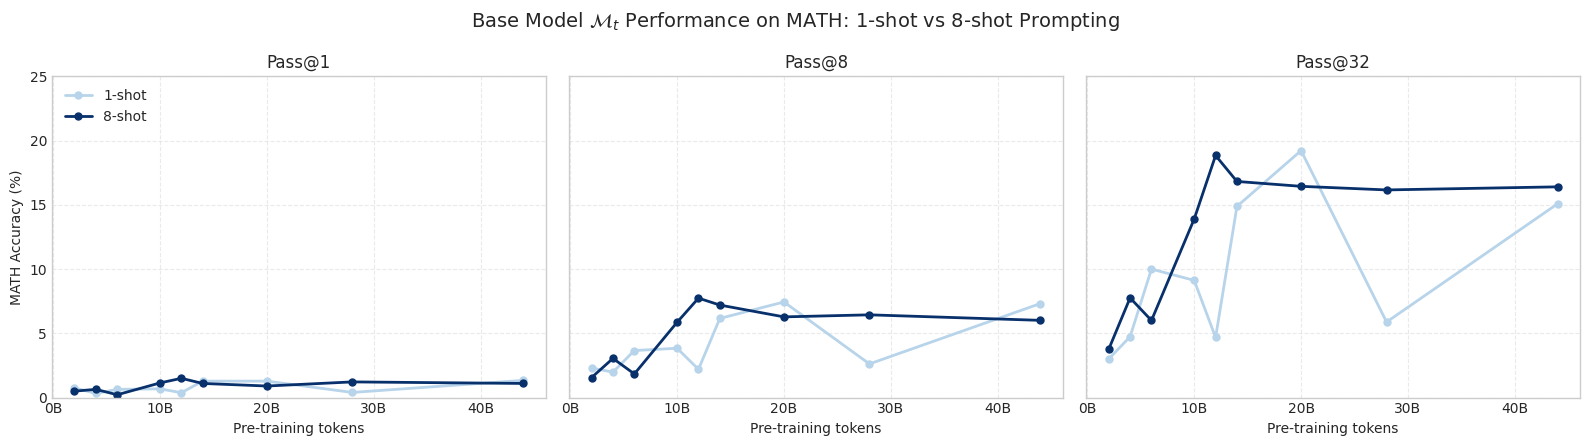

In [7]:
# Plot 1: Base model performance comparison - 0-shot vs 1-shot vs 8-shot for pass@1, pass@8, pass@32
PLOT_SAMPLES_BASE = [1, 8, 32]
SHOT_COMPARISON = [1, 8]  # MATH only has 1-shot and 8-shot data
TARGET_TEMP = 0.6
TOKENS_PER_STEP = 2_000_000  # 2M tokens per step

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)
cmap = plt.get_cmap("Blues")

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    for shot_idx, shot in enumerate(SHOT_COMPARISON):
        # Color gradient: lighter for 1-shot, darker for 8-shot
        color = cmap(0.3 + 0.7 * shot_idx / (len(SHOT_COMPARISON) - 1))

        # Filter pre-train data for this samples/shot/temp combination
        pre_curve = pre_df[
            (pre_df["samples"] == samples) &
            (pre_df["shot"] == shot) &
            (pre_df["temp"] == TARGET_TEMP)
        ].sort_values("step")

        if not pre_curve.empty:
            tokens_billions = pre_curve["step"] * TOKENS_PER_STEP / 1e9
            ax.plot(
                tokens_billions,
                pre_curve["score"] * 100,
                marker="o",
                markersize=5,
                color=color,
                label=f"{shot}-shot",
                linewidth=2
            )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("Pre-training tokens")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:g}B"))
    if idx == 0:
        ax.set_ylabel(f"{DATASET_NAME} Accuracy (%)")
    ax.set_ylim(0, 25)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left")

fig.suptitle(r"Base Model $\mathcal{M}_t$ Performance on MATH: 1-shot vs 8-shot Prompting", fontsize=14)
plt.tight_layout()
fig.savefig("/n/home05/sqin/rl_pretrain/verl/notebooks/math_base_eval_shots.pdf", bbox_inches="tight")
plt.show() 

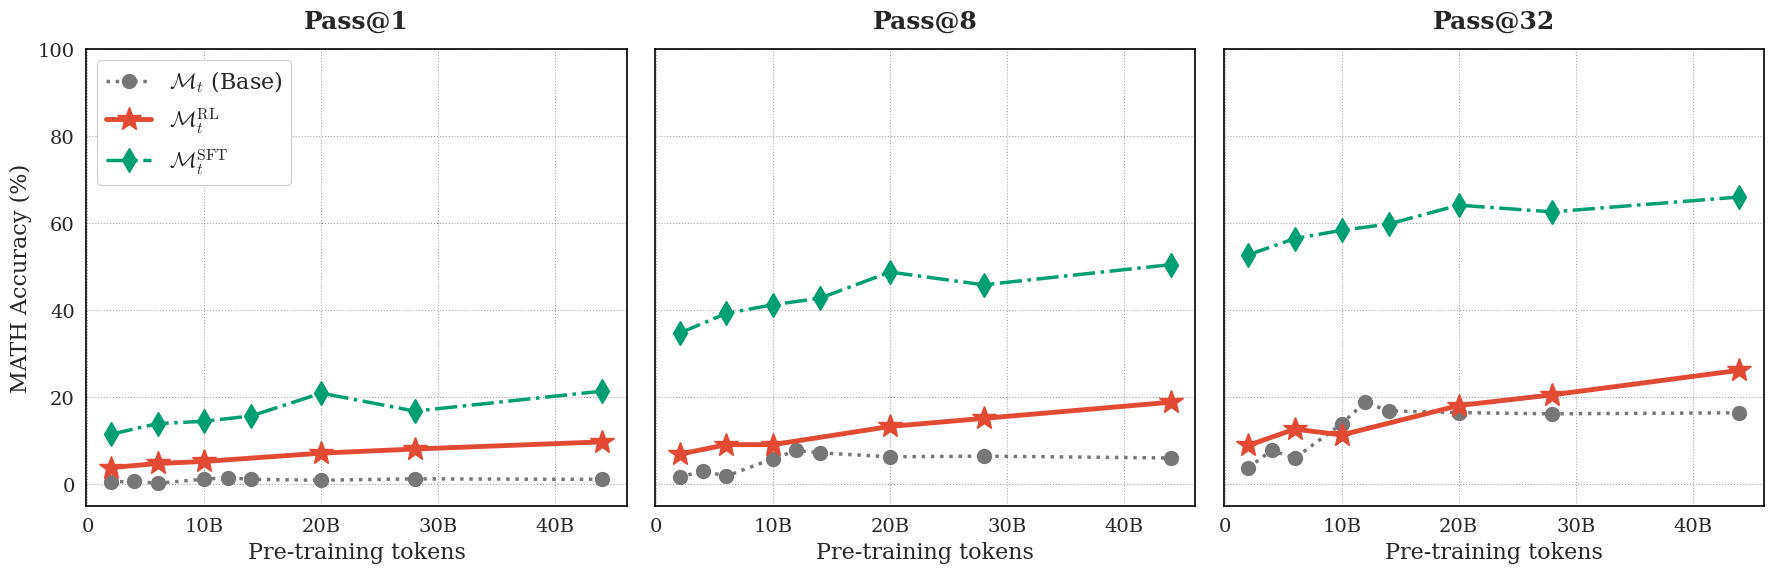

In [100]:
# Plot 3: Base model (8-shot) vs RL (last ckpt) vs SFT (5-epoch openmath, last ckpt)
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 1. Setup Theme
sns.set_theme(style="whitegrid", context="paper", font_scale=1.6)

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
})

# Constants
PLOT_SAMPLES_BASE = [1, 8, 32]
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 64  # Using n=64 for MATH
SFT_EPOCHS = 5
SFT_DATASET = "openmath"
TOKEN_MULTIPLIER = 2_000_000

# 2. COLOR PALETTE (Okabe-Ito / High Contrast)
color_base = "#777777"     # Gray
color_rl = "#E24A33"       # Red
color_sft = "#009E73"      # Emerald Green

# 3. Styles
styles = {
    "pretrain": {
        "color": color_base,
        "marker": "o", "ls": ":", "markersize": 10,
        "linewidth": 2.5,
        "label": r"$\mathcal{M}_t$ (Base)"
    },
    "sft": {
        "color": color_sft,
        "marker": "d", "ls": "-.", "markersize": 12,
        "linewidth": 2.5,
        "label": r"$\mathcal{M}_t^{\text{SFT}}$"
    },
    "rl": {
        "color": color_rl,
        "marker": "*", "ls": "-", "markersize": 18,
        "linewidth": 3.5,
        "label": r"$\mathcal{M}_t^{\text{RL}}$"
    }
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# X-axis formatter
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.0f%s' % (num, ['', 'K', 'M', 'B', 'T'][magnitude])
formatter = FuncFormatter(human_format)

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    # --- Plotting Series ---

    # 1. Base
    pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == TARGET_SHOT) & (pre_df["temp"] == TARGET_TEMP)].sort_values("step")
    if not pre_curve.empty:
        ax.plot(pre_curve["step"] * TOKEN_MULTIPLIER, pre_curve["score"] * 100, **styles["pretrain"])

    # 2. SFT
    if not sft_df.empty:
        sft_subset = sft_df[
            (sft_df["samples"] == samples) &
            (sft_df["temp"] == TARGET_TEMP) &
            (sft_df["sft_epochs"] == SFT_EPOCHS) &
            (sft_df["sft_dataset"] == SFT_DATASET)
        ]
        if not sft_subset.empty:
            sft_last = sft_subset.loc[sft_subset.groupby("pt_step")["sft_step"].idxmax()].sort_values("pt_step")
            ax.plot(sft_last["pt_step"] * TOKEN_MULTIPLIER, sft_last["score"] * 100, **styles["sft"])

    # 3. RL Only
    rl_subset = rl_df[(rl_df["samples"] == samples) & (rl_df["temp"] == TARGET_TEMP) & (rl_df["num_rollouts"] == RL_ROLLOUTS)]
    if not rl_subset.empty:
        rl_last = rl_subset.loc[rl_subset.groupby("pt_step")["rl_step"].idxmax()].sort_values("pt_step")
        ax.plot(rl_last["pt_step"] * TOKEN_MULTIPLIER, rl_last["score"] * 100, **styles["rl"], zorder=10)

    # --- Formatting ---
    ax.set_title(f"Pass@{samples}", fontweight="bold", pad=15)
    ax.set_xlabel("Pre-training tokens")
    ax.xaxis.set_major_formatter(formatter)

    if idx == 0:
        ax.set_ylabel(f"{DATASET_NAME} Accuracy (%)")

        # --- Legend Sorting ---
        handles, labels = ax.get_legend_handles_labels()
        desired_order = [
            styles["pretrain"]["label"],
            styles["rl"]["label"],
            styles["sft"]["label"],
        ]
        order_lookup = {label: i for i, label in enumerate(desired_order)}
        sorted_pairs = sorted(zip(handles, labels), key=lambda pair: order_lookup.get(pair[1], 99))
        sorted_handles, sorted_labels = zip(*sorted_pairs)

        ax.legend(sorted_handles, sorted_labels, frameon=True, framealpha=0.95, loc="upper left", fontsize=16)

    ax.set_ylim(-5, 100)

    # --- Darker Grid Lines ---
    ax.grid(True, linestyle=":", color="gray", alpha=0.7)

    # Full Borders
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

Found pt_steps: [1000, 3000, 5000, 6000, 7000, 10000, 14000, 22000]


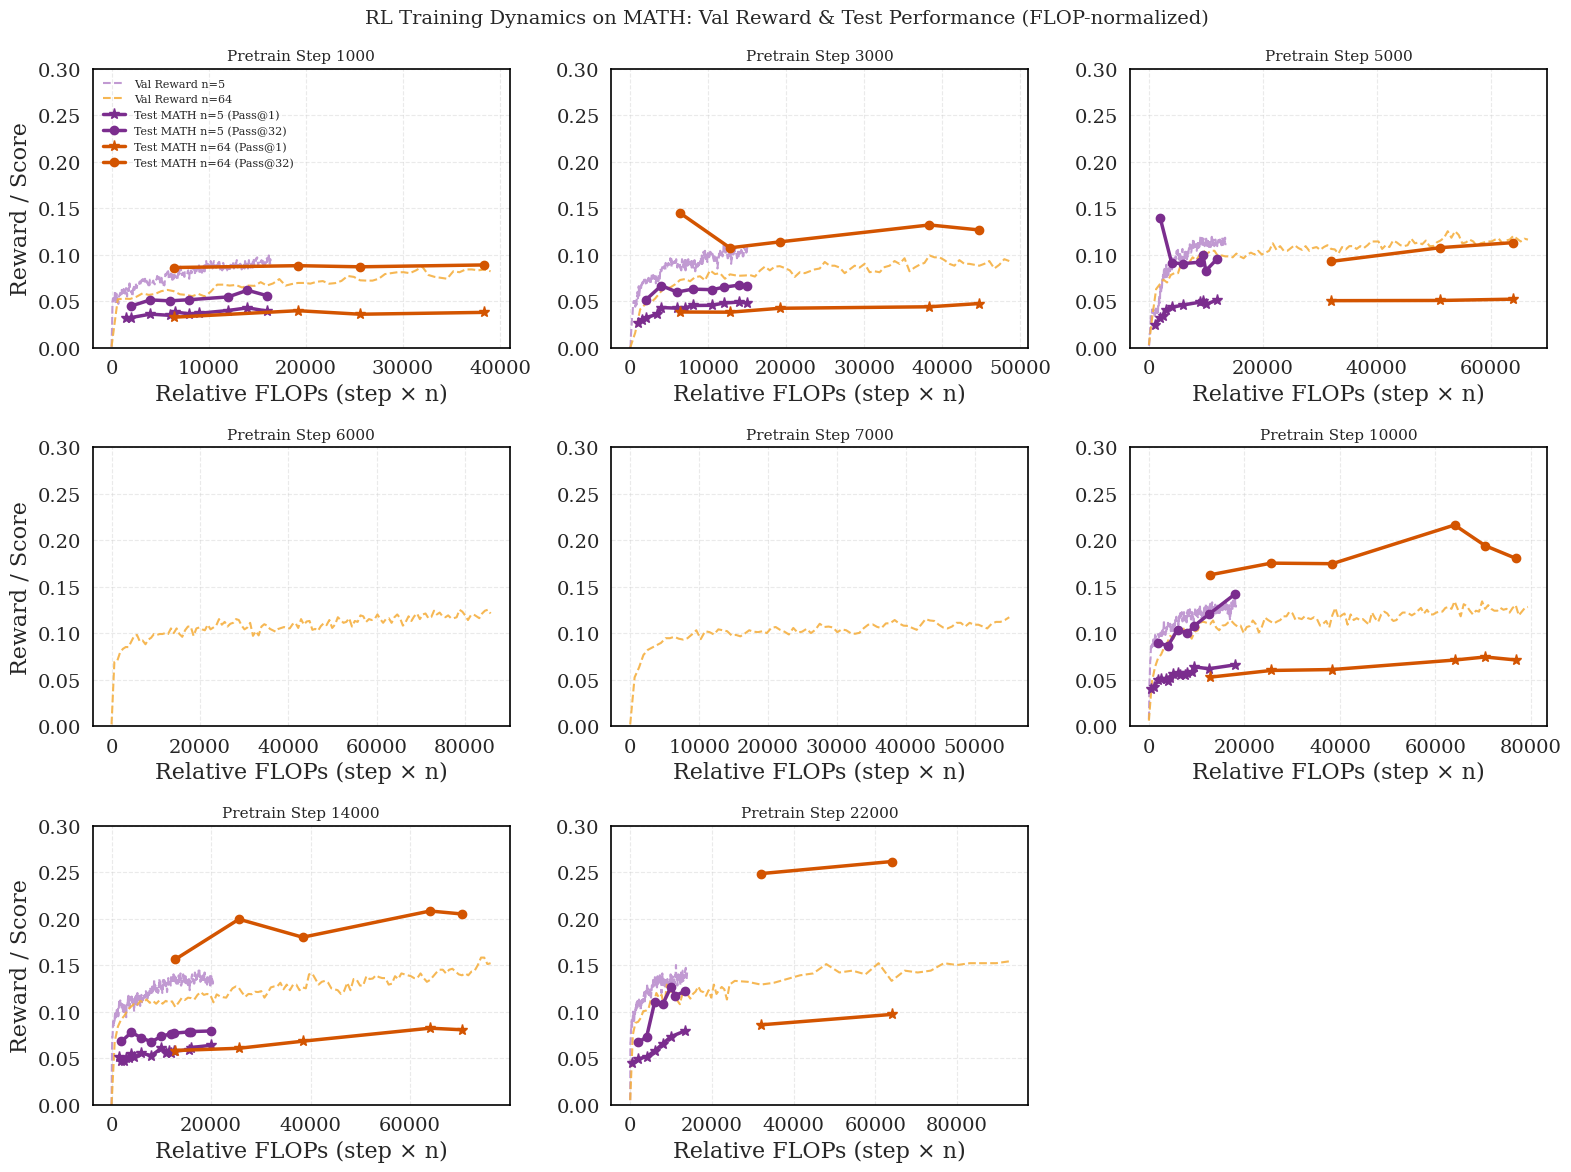

In [101]:
# Plot 4: RL Training Dynamics - 3x3 grid for each pt_step (using combined CSV files)
# Each subplot shows: (1) validation reward for n=5 and n=64, (2) test MATH performance for n=5 and n=64
# X-axis normalized by FLOPs (step × n, since FLOPs ∝ n per step)
import os
import re

RESULT_FILES_DIR = "/n/home05/sqin/rl_pretrain/verl/notebooks/result_files"
VAL_N5_CSV = os.path.join(RESULT_FILES_DIR, "stepsall_omi_n5_val_reward.csv")
VAL_N64_CSV = os.path.join(RESULT_FILES_DIR, "stepsall_omi_n64_val_reward.csv")
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS_LIST = [5, 64]  # Plot both n=5 and n=64
TARGET_SAMPLES_LIST = [1, 32]  # Plot both pass@1 and pass@32

# Load the validation CSVs
val_n5_df = pd.read_csv(VAL_N5_CSV)
val_n64_df = pd.read_csv(VAL_N64_CSV)

# Extract pt_steps from column headers (format: "Name: olmo2_1b_step{pt_step}_omi_n64 - ...")
def extract_pt_steps_from_columns(df, pattern=r"step(\d+)_omi"):
    pt_steps = set()
    for col in df.columns:
        match = re.search(pattern, col)
        if match:
            pt_steps.add(int(match.group(1)))
    return sorted(pt_steps)

pt_steps_from_files = extract_pt_steps_from_columns(val_n64_df)
print(f"Found pt_steps: {pt_steps_from_files}")

# Create 3x3 grid
n_steps = len(pt_steps_from_files)
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12), sharey=False)
axes = axes.flatten()

# Colors: similar shades for val vs test within each n
# n=5: purples, n=64: oranges
test_colors = {5: "#7B2D8E", 64: "#D35400"}   # darker: dark purple, dark orange
val_colors = {5: "#BB8FCE", 64: "#F5B041"}    # lighter: light purple, light orange

# Markers for different pass@k
markers = {1: "*", 32: "o"}  # star for pass@1, circle for pass@32

for idx, pt_step in enumerate(pt_steps_from_files):
    if idx >= nrows * ncols:
        break
    ax = axes[idx]
    
    # Plot validation reward for both n=5 and n=64 (dashed lines)
    for rl_rollouts, val_df in [(5, val_n5_df), (64, val_n64_df)]:
        val_col = None
        for col in val_df.columns:
            if f"step{pt_step}_omi" in col and "__MIN" not in col and "__MAX" not in col:
                val_col = col
                break
        
        if val_col:
            val_data = val_df[["Step", val_col]].dropna()
            val_data = val_data.copy()
            val_data[val_col] = pd.to_numeric(val_data[val_col], errors='coerce')
            val_data = val_data.dropna()
            if not val_data.empty:
                # Normalize x-axis by FLOPs: step × n
                flop_normalized_steps = val_data["Step"] * rl_rollouts
                ax.plot(flop_normalized_steps, val_data[val_col], color=val_colors[rl_rollouts], 
                        alpha=0.9, label=f"Val Reward n={rl_rollouts}", linewidth=1.5, linestyle="--")
    
    # Plot test MATH performance for each rollout config and each pass@k (solid lines, thicker)
    for rl_rollouts in RL_ROLLOUTS_LIST:
        for target_samples in TARGET_SAMPLES_LIST:
            rl_subset = rl_df[
                (rl_df["pt_step"] == pt_step) &
                (rl_df["samples"] == target_samples) &
                (rl_df["temp"] == TARGET_TEMP) &
                (rl_df["num_rollouts"] == rl_rollouts)
            ].sort_values("rl_step")
            
            if not rl_subset.empty:
                test_steps = rl_subset["rl_step"].tolist()
                test_scores = rl_subset["score"].tolist()
                
                # Normalize x-axis by FLOPs: step × n
                flop_normalized_steps = [s * rl_rollouts for s in test_steps]
                ax.plot(flop_normalized_steps, test_scores, color=test_colors[rl_rollouts], 
                        marker=markers[target_samples], markersize=8 if target_samples == 1 else 6,
                        label=f"Test {DATASET_NAME} n={rl_rollouts} (Pass@{target_samples})", 
                        linewidth=2.5, linestyle="-")
    
    ax.set_title(f"Pretrain Step {pt_step}", fontsize=11)
    ax.set_xlabel("Relative FLOPs (step × n)")
    if idx % ncols == 0:
        ax.set_ylabel("Reward / Score")
    ax.set_ylim(0, 0.3)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left", fontsize=8)

# Hide unused subplots
for idx in range(len(pt_steps_from_files), nrows * ncols):
    axes[idx].set_visible(False)

fig.suptitle(f"RL Training Dynamics on {DATASET_NAME}: Val Reward & Test Performance (FLOP-normalized)", fontsize=14)
plt.tight_layout()
plt.show()

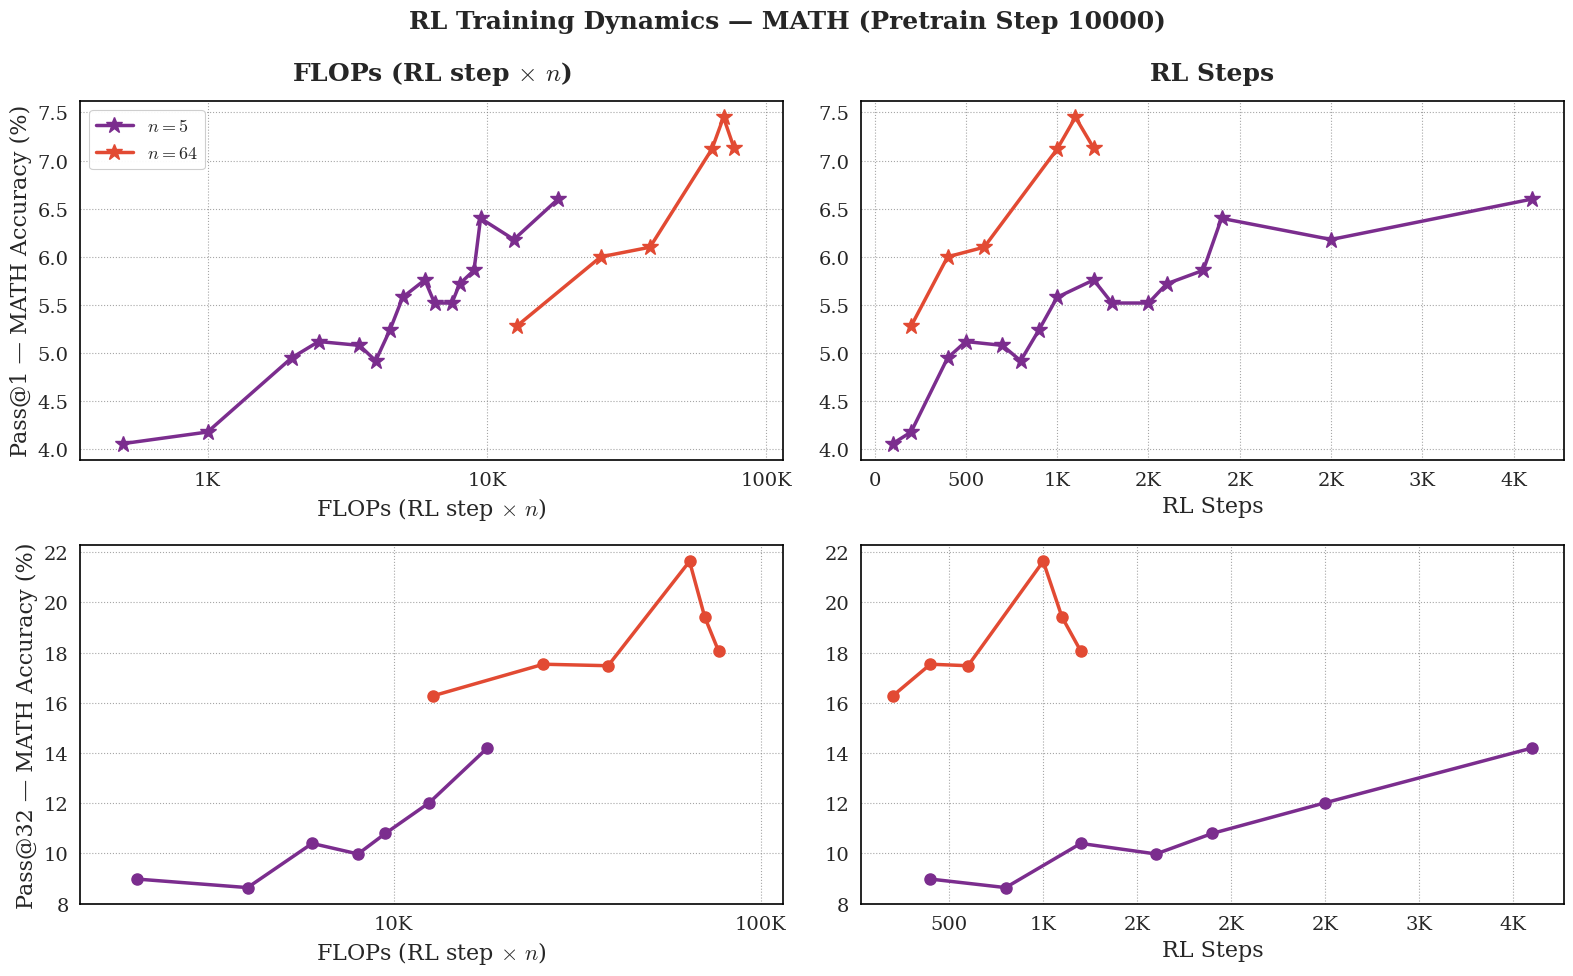

In [102]:
# Plot 5: RL Training Dynamics for pt_step=14000 (FLOPs vs RL Steps)
# Top row: Pass@1, Bottom row: Pass@32
# Left column: FLOPs (log-scaled), Right column: RL Steps
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid", context="paper", font_scale=1.6)

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
})

# Constants
PT_STEP = 10000
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS_LIST = [5, 64]
TARGET_SAMPLES_LIST = [1, 32]

# X-axis formatter
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.0f%s' % (num, ['', 'K', 'M', 'B', 'T'][magnitude])
formatter = FuncFormatter(human_format)

# Colors per rollout config (Okabe-Ito inspired)
test_colors = {5: "#7B2D8E", 64: "#E24A33"}   # purple, red
test_labels = {5: r"$n{=}5$", 64: r"$n{=}64$"}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

x_modes = ["flops", "rl_steps"]
x_labels_map = {"flops": r"FLOPs (RL step $\times$ $n$)", "rl_steps": "RL Steps"}

for row_idx, target_samples in enumerate(TARGET_SAMPLES_LIST):
    for col_idx, x_mode in enumerate(x_modes):
        ax = axes[row_idx, col_idx]

        # Test MATH performance
        all_xs = []
        for rl_rollouts in RL_ROLLOUTS_LIST:
            rl_subset = rl_df[
                (rl_df["pt_step"] == PT_STEP) &
                (rl_df["samples"] == target_samples) &
                (rl_df["temp"] == TARGET_TEMP) &
                (rl_df["num_rollouts"] == rl_rollouts)
            ].sort_values("rl_step")

            if not rl_subset.empty:
                if x_mode == "flops":
                    xs = (rl_subset["rl_step"] * rl_rollouts).tolist()
                else:
                    xs = rl_subset["rl_step"].tolist()

                all_xs.extend(xs)
                ax.plot(xs, rl_subset["score"] * 100,
                        color=test_colors[rl_rollouts],
                        marker="*" if target_samples == 1 else "o",
                        markersize=12 if target_samples == 1 else 8,
                        label=test_labels[rl_rollouts],
                        linewidth=2.5, linestyle="-", zorder=10)

        # Formatting
        if x_mode == "flops":
            ax.set_xscale("log")
            if all_xs:
                ax.set_xlim(min(all_xs) * 0.7, max(all_xs) * 1.5)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_xlabel(x_labels_map[x_mode])

        if row_idx == 0:
            ax.set_title(x_labels_map[x_mode], fontweight="bold", pad=15)

        if col_idx == 0:
            ax.set_ylabel(f"Pass@{target_samples} — {DATASET_NAME} Accuracy (%)")

        # Legend only on top-left panel
        if row_idx == 0 and col_idx == 0:
            handles, labels = ax.get_legend_handles_labels()
            desired_order = [test_labels[5], test_labels[64]]
            order_lookup = {label: i for i, label in enumerate(desired_order)}
            sorted_pairs = sorted(zip(handles, labels), key=lambda pair: order_lookup.get(pair[1], 99))
            sorted_handles, sorted_labels = zip(*sorted_pairs)
            ax.legend(sorted_handles, sorted_labels, frameon=True, framealpha=0.95,
                      loc="upper left", fontsize=13)

        ax.grid(True, linestyle=":", color="gray", alpha=0.7)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.2)

fig.suptitle(f"RL Training Dynamics — {DATASET_NAME} (Pretrain Step {PT_STEP})", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()

In [103]:
# Plot 6: RL Training Dynamics for GSM8K - 3x3 grid for each pt_step
# Same as Plot 4 but for GSM8K scores instead of MATH
# X-axis normalized by FLOPs (step × n, since FLOPs ∝ n per step)
import os
import re

# Directories for GSM8K results (same as MATH)
GSM8K_DIRS = BASE_DIRS

# First, collect GSM8K evaluation data
GSM8K_DATASET_KEY = "test_score/openai/gsm8k"

def read_gsm8k_score(result_path: Path, samples: int):
    """Read GSM8K score from result files."""
    if not result_path.exists():
        return {}

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        scores = {}
        for line in text:
            if "Pass@" in line and ":" in line:
                k_match = re.search(r"Pass@(\d+)", line)
                if k_match:
                    k = int(k_match.group(1))
                    parts = line.split(":")
                    if len(parts) > 1:
                        try:
                            score = float(parts[1].split()[0])
                            scores[k] = score
                        except Exception:
                            pass
        if scores:
            return scores

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and GSM8K_DATASET_KEY in payload:
            return {samples: payload[GSM8K_DATASET_KEY]}
    return {}

# Patterns for GSM8K
gsm8k_pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")
gsm8k_rl_patterns = [
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omi_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
]

# Collect GSM8K data from all directories
gsm8k_pre_rows = []
gsm8k_rl_rows = []

print("Collecting GSM8K data...")
for GSM8K_DIR in GSM8K_DIRS:
    if not GSM8K_DIR.exists():
        print(f"  Warning: {GSM8K_DIR} does not exist, skipping...")
        continue
    
    print(f"  Collecting from: {GSM8K_DIR}")
    
    for path in GSM8K_DIR.iterdir():
        if not path.is_dir():
            continue
        name = path.name

        # Pre-train collection
        pre_match = gsm8k_pre_pattern.match(name)
        if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
            samples = int(pre_match.group("samples"))
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            scores_dict = read_gsm8k_score(path / result_file, samples=samples)
            
            for k, score in scores_dict.items():
                gsm8k_pre_rows.append({
                    "step": int(pre_match.group("step")),
                    "shot": int(pre_match.group("shot")),
                    "samples": k,
                    "temp": float(pre_match.group("temp")),
                    "score": score,
                    "path": str(path),
                })
            continue

        # RL collection
        for pat in gsm8k_rl_patterns:
            rl_match = pat.match(name)
            if rl_match:
                samples = int(rl_match.group("samples"))
                result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
                scores_dict = read_gsm8k_score(path / result_file, samples=samples)
                pt_step = int(rl_match.group("pt_step"))
                rl_step = int(rl_match.group("rl_step"))
                num_rollouts = int(rl_match.group("num_rollouts"))
                
                for k, score in scores_dict.items():
                    gsm8k_rl_rows.append({
                        "pt_step": pt_step,
                        "rl_step": rl_step,
                        "total_step": pt_step + rl_step,
                        "samples": k,
                        "temp": float(rl_match.group("temp")),
                        "score": score,
                        "path": str(path),
                        "label": name,
                        "num_rollouts": num_rollouts,
                    })
                break

gsm8k_rl_df = pd.DataFrame(gsm8k_rl_rows)
gsm8k_pre_df = pd.DataFrame(gsm8k_pre_rows)

print(f"Loaded {len(gsm8k_pre_df)} GSM8K pre-train runs, {len(gsm8k_rl_df)} GSM8K RL runs")

# Remove duplicates
if not gsm8k_rl_df.empty:
    gsm8k_rl_df = gsm8k_rl_df.drop_duplicates(subset=['pt_step', 'rl_step', 'samples', 'temp', 'num_rollouts'], keep='first')
if not gsm8k_pre_df.empty:
    gsm8k_pre_df = gsm8k_pre_df.drop_duplicates(subset=['step', 'shot', 'samples', 'temp'], keep='first')

print(f"After dedup: {len(gsm8k_pre_df)} GSM8K pre-train runs, {len(gsm8k_rl_df)} GSM8K RL runs")

# Show breakdown by num_rollouts
if not gsm8k_rl_df.empty:
    print("\nGSM8K RL runs by num_rollouts:")
    print(gsm8k_rl_df.groupby('num_rollouts').size()) 

Loaded 124 GSM8K pre-train runs, 559 GSM8K RL runs
After dedup: 124 GSM8K pre-train runs, 478 GSM8K RL runs

GSM8K RL runs by num_rollouts:
num_rollouts
5     327
64    151
dtype: int64


Plotting GSM8K for pt_steps: [1000, 3000, 5000, 6000, 7000, 10000, 14000, 22000]


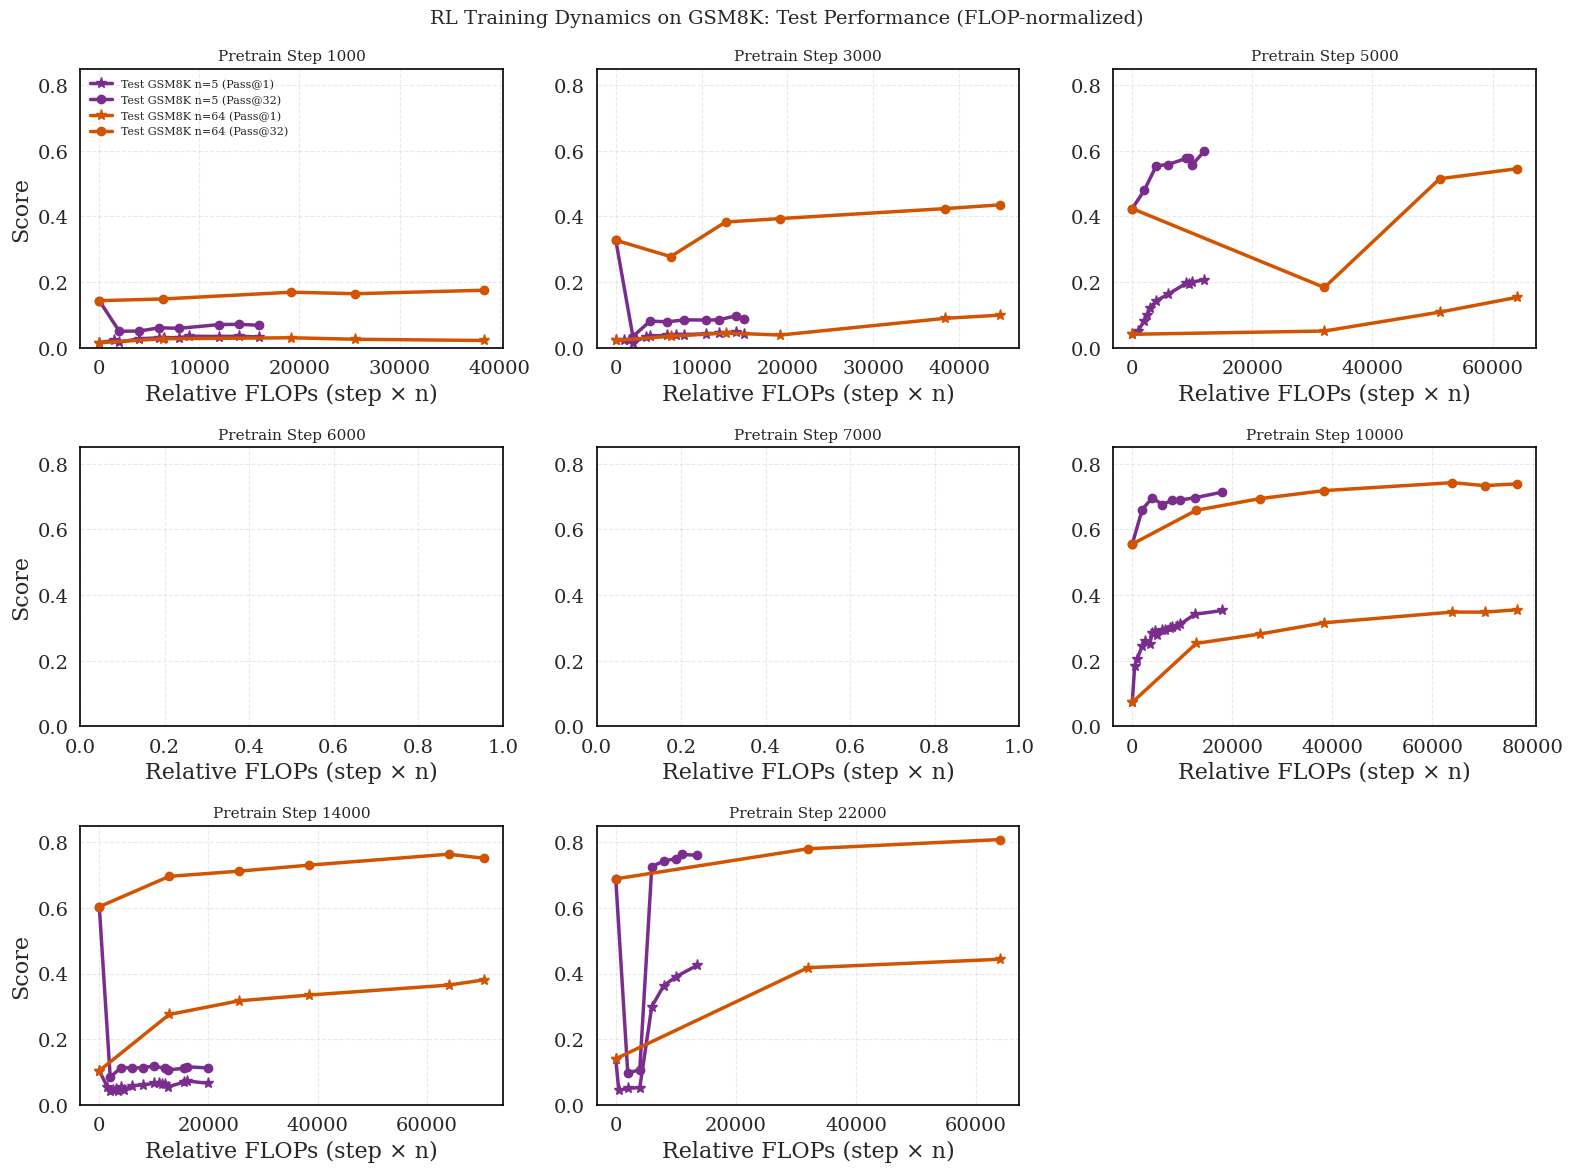

In [104]:
# Plot 6: GSM8K RL Training Dynamics - 3x3 grid for each pt_step
# Same structure as Plot 4 but for GSM8K scores (no val rewards)
# X-axis normalized by FLOPs (step × n, since FLOPs ∝ n per step)

GSM8K_DATASET_NAME = "GSM8K"
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS_LIST = [5, 64]
TARGET_SAMPLES_LIST = [1, 32]  # Plot both pass@1 and pass@32

# Use the same pt_steps as Plot 4
pt_steps_for_plot = extract_pt_steps_from_columns(val_n64_df)
print(f"Plotting GSM8K for pt_steps: {pt_steps_for_plot}")

# Create 3x3 grid
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12), sharey=False)
axes = axes.flatten()

# Colors for each n
# n=5: purples, n=64: oranges
test_colors = {5: "#7B2D8E", 64: "#D35400"}   # dark purple, dark orange

# Markers for different pass@k
markers = {1: "*", 32: "o"}  # star for pass@1, circle for pass@32

for idx, pt_step in enumerate(pt_steps_for_plot):
    if idx >= nrows * ncols:
        break
    ax = axes[idx]
    
    # Plot test GSM8K performance for each rollout config and each pass@k (solid lines, thicker)
    for rl_rollouts in RL_ROLLOUTS_LIST:
        for target_samples in TARGET_SAMPLES_LIST:
            rl_subset = gsm8k_rl_df[
                (gsm8k_rl_df["pt_step"] == pt_step) &
                (gsm8k_rl_df["samples"] == target_samples) &
                (gsm8k_rl_df["temp"] == TARGET_TEMP) &
                (gsm8k_rl_df["num_rollouts"] == rl_rollouts)
            ].sort_values("rl_step")
            
            if not rl_subset.empty:
                # Get pre-train score for rl_step=0
                pre_score = gsm8k_pre_df[
                    (gsm8k_pre_df["step"] == pt_step) &
                    (gsm8k_pre_df["samples"] == target_samples) &
                    (gsm8k_pre_df["shot"] == TARGET_SHOT) &
                    (gsm8k_pre_df["temp"] == TARGET_TEMP)
                ]
                
                if not pre_score.empty:
                    test_steps = [0] + rl_subset["rl_step"].tolist()
                    test_scores = [pre_score.iloc[0]["score"]] + rl_subset["score"].tolist()
                else:
                    test_steps = rl_subset["rl_step"].tolist()
                    test_scores = rl_subset["score"].tolist()
                
                # Normalize x-axis by FLOPs: step × n
                flop_normalized_steps = [s * rl_rollouts for s in test_steps]
                ax.plot(flop_normalized_steps, test_scores, color=test_colors[rl_rollouts], 
                        marker=markers[target_samples], markersize=8 if target_samples == 1 else 6,
                        label=f"Test {GSM8K_DATASET_NAME} n={rl_rollouts} (Pass@{target_samples})", 
                        linewidth=2.5, linestyle="-")
    
    ax.set_title(f"Pretrain Step {pt_step}", fontsize=11)
    ax.set_xlabel("Relative FLOPs (step × n)")
    if idx % ncols == 0:
        ax.set_ylabel("Score")
    ax.set_ylim(0, 0.85)  # GSM8K scores are higher than MATH
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left", fontsize=8)

# Hide unused subplots
for idx in range(len(pt_steps_for_plot), nrows * ncols):
    axes[idx].set_visible(False)

fig.suptitle(f"RL Training Dynamics on {GSM8K_DATASET_NAME}: Test Performance (FLOP-normalized)", fontsize=14)
plt.tight_layout()
plt.show()

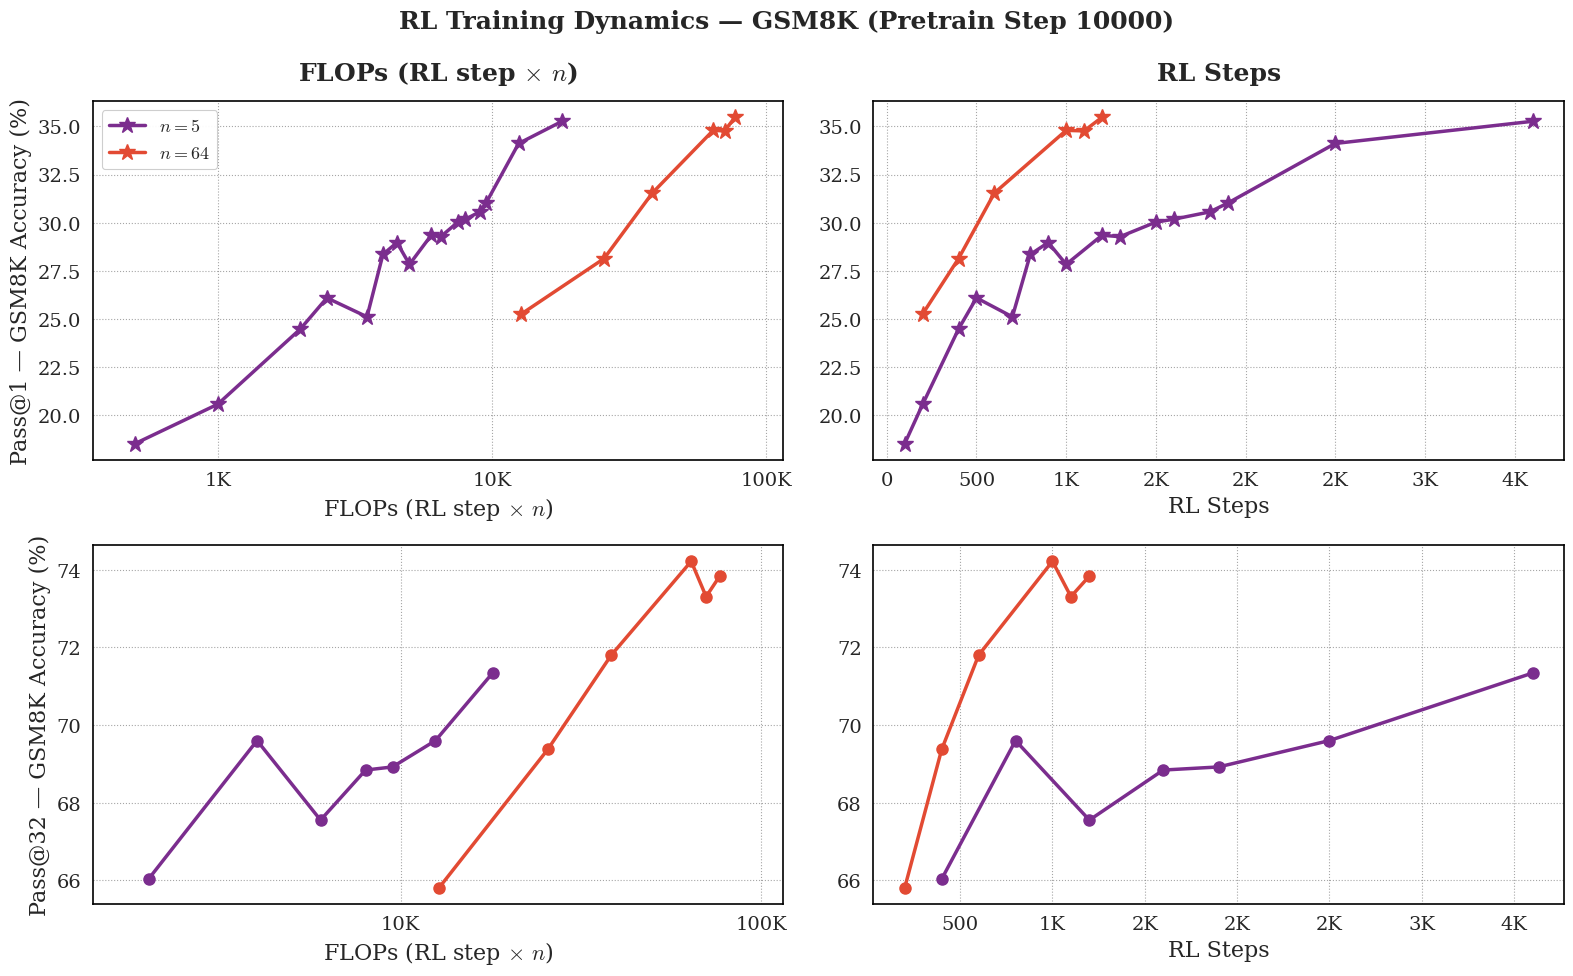

In [105]:
# Plot 7: GSM8K RL Training Dynamics for pt_step=14000 (FLOPs vs RL Steps)
# Top row: Pass@1, Bottom row: Pass@32
# Left column: FLOPs (log-scaled), Right column: RL Steps
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid", context="paper", font_scale=1.6)

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
})

# Constants
PT_STEP = 10000
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS_LIST = [5, 64]
TARGET_SAMPLES_LIST = [1, 32]
GSM8K_DATASET_NAME = "GSM8K"

# X-axis formatter
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.0f%s' % (num, ['', 'K', 'M', 'B', 'T'][magnitude])
formatter = FuncFormatter(human_format)

# Colors per rollout config (Okabe-Ito inspired)
test_colors = {5: "#7B2D8E", 64: "#E24A33"}   # purple, red
test_labels = {5: r"$n{=}5$", 64: r"$n{=}64$"}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

x_modes = ["flops", "rl_steps"]
x_labels_map = {"flops": r"FLOPs (RL step $\times$ $n$)", "rl_steps": "RL Steps"}

for row_idx, target_samples in enumerate(TARGET_SAMPLES_LIST):
    for col_idx, x_mode in enumerate(x_modes):
        ax = axes[row_idx, col_idx]

        # Test GSM8K performance
        all_xs = []
        for rl_rollouts in RL_ROLLOUTS_LIST:
            rl_subset = gsm8k_rl_df[
                (gsm8k_rl_df["pt_step"] == PT_STEP) &
                (gsm8k_rl_df["samples"] == target_samples) &
                (gsm8k_rl_df["temp"] == TARGET_TEMP) &
                (gsm8k_rl_df["num_rollouts"] == rl_rollouts)
            ].sort_values("rl_step")

            if not rl_subset.empty:
                if x_mode == "flops":
                    xs = (rl_subset["rl_step"] * rl_rollouts).tolist()
                else:
                    xs = rl_subset["rl_step"].tolist()

                all_xs.extend(xs)
                ax.plot(xs, rl_subset["score"] * 100,
                        color=test_colors[rl_rollouts],
                        marker="*" if target_samples == 1 else "o",
                        markersize=12 if target_samples == 1 else 8,
                        label=test_labels[rl_rollouts],
                        linewidth=2.5, linestyle="-", zorder=10)

        # Formatting
        if x_mode == "flops":
            ax.set_xscale("log")
            if all_xs:
                ax.set_xlim(min(all_xs) * 0.7, max(all_xs) * 1.5)
        ax.xaxis.set_major_formatter(formatter)
        ax.set_xlabel(x_labels_map[x_mode])

        if row_idx == 0:
            ax.set_title(x_labels_map[x_mode], fontweight="bold", pad=15)

        if col_idx == 0:
            ax.set_ylabel(f"Pass@{target_samples} — {GSM8K_DATASET_NAME} Accuracy (%)")

        # Legend only on top-left panel
        if row_idx == 0 and col_idx == 0:
            handles, labels = ax.get_legend_handles_labels()
            desired_order = [test_labels[5], test_labels[64]]
            order_lookup = {label: i for i, label in enumerate(desired_order)}
            sorted_pairs = sorted(zip(handles, labels), key=lambda pair: order_lookup.get(pair[1], 99))
            sorted_handles, sorted_labels = zip(*sorted_pairs)
            ax.legend(sorted_handles, sorted_labels, frameon=True, framealpha=0.95,
                      loc="upper left", fontsize=13)

        ax.grid(True, linestyle=":", color="gray", alpha=0.7)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.2)

fig.suptitle(f"RL Training Dynamics — {GSM8K_DATASET_NAME} (Pretrain Step {PT_STEP})", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()

In [106]:
# fineweb-math for pre-training
# tiny-gsm numbers
# how back we can push the RL
# maybe we can push it way back and make up for pre-training but having to spend lot more FLOPs on RL
# poking around datasets

In [107]:
# Concise table with columns for pass@1/8/32/128 (pre, best SFT, best RL)
TARGET_KS = [1, 8, 32, 128]

rows = []
all_steps = sorted(pre_df["step"].unique().tolist()) if not pre_df.empty else []
for step in all_steps:
    row = {"pt_step": step}
    for k in TARGET_KS:
        temp = TEMP_BY_SAMPLES(k)
        shot = SHOT_BY_SAMPLES(k)

        # Pre-train
        if not pre_df.empty:
            pre_slice = pre_df[(pre_df["step"] == step) & (pre_df["samples"] == k) & (pre_df["temp"] == temp) & (pre_df["shot"] == shot)]
            row[f"pre_p{k}"] = pre_slice.iloc[-1]["score"] if not pre_slice.empty else None
        else:
            row[f"pre_p{k}"] = None

        # SFT
        if not sft_df.empty:
            sft_slice = sft_df[(sft_df["pt_step"] == step) & (sft_df["samples"] == k) & (sft_df["temp"] == temp)]
            if not sft_slice.empty:
                best_sft = sft_slice.loc[sft_slice["total_step"].idxmax()]
                row[f"sft_p{k}"] = best_sft["score"]
            else:
                row[f"sft_p{k}"] = None
        else:
            row[f"sft_p{k}"] = None

        # RL
        if not rl_df.empty:
            rl_slice = rl_df[(rl_df["pt_step"] == step) & (rl_df["samples"] == k) & (rl_df["temp"] == temp)]
            if not rl_slice.empty:
                best_rl = rl_slice.loc[rl_slice["total_step"].idxmax()]
                row[f"rl_p{k}"] = best_rl["score"]
            else:
                row[f"rl_p{k}"] = None
        else:
            row[f"rl_p{k}"] = None

    rows.append(row)

concise_df = pd.DataFrame(rows).sort_values("pt_step").reset_index(drop=True) if rows else pd.DataFrame()
concise_df


,pt_step,pre_p1,sft_p1,rl_p1,pre_p8,sft_p8,rl_p8,pre_p32,sft_p32,rl_p32,pre_p128,sft_p128,rl_p128
0,1000,0.0050,0.1146,0.0394,0.0156,0.3469,0.0516,0.0376,0.5268,0.0560,None,None,NaN
1,2000,0.0064,0.0156,NaN,0.0305,0.0918,NaN,0.0776,0.2228,NaN,None,None,NaN
2,3000,0.0022,0.1391,0.0480,0.0184,0.3924,0.0610,0.0600,0.5644,0.0660,None,None,NaN
3,5000,0.0114,0.1445,0.0514,0.0586,0.4122,0.0763,0.1390,0.5832,0.0956,None,None,0.0988
4,6000,0.0150,0.0254,NaN,0.0774,0.1207,NaN,0.1884,0.2614,NaN,None,None,NaN
5,7000,0.0110,0.1568,NaN,0.0720,0.4272,NaN,0.1682,0.5976,NaN,None,None,NaN
6,10000,0.0090,0.2091,0.0660,0.0628,0.4873,0.1098,0.1644,0.6410,0.1420,None,None,NaN
7,14000,0.0122,0.1678,0.0640,0.0644,0.4580,0.0751,0.1616,0.6256,0.0794,None,None,NaN
8,22000,0.0110,0.2137,0.0796,0.0601,0.5043,0.1044,0.1640,0.6598,0.1222,None,None,NaN
